This tutorial demonstrates a basic usage of the image formation pipeline in `cryojax`.

It will demonstrate almost all of the modeling components that can be used when simulating a single image. This includes models for the instrument optics, electron dose rate, detector, and solvent. These models are all a work in progress.

In [1]:
# Jax imports
import jax

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cs
from cryojax.image import operators as op
from cryojax.io import read_array_with_spacing_from_mrc

In [4]:
# Scattering potential stored in MRC format
filename = "../../tests/data/3j9g_potential_ps4_4.mrc"

First we must read in our 3D scattering potential into a given voxel-based representation of the `potential`. Here, this is the `FourierVoxelGrid`. Then, we choose an integration method onto the exit plane.  Here, we use the fourier-slice projection theorem with the `FourierSliceExtract` integrator. In general, the `integrator` will depend on the scattering potential representation.

In [5]:
# Read template into a FourierVoxelGridPotential and choose an integrator
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
integrator = cs.FourierSliceExtract(interpolation_order=1)

Next, we must instantiate the biological specimen. A `Specimen` takes in the `potential`, `integrator`, and also a `pose`. Here, we represent the `pose` with an `EulerAnglePose`.

In [6]:
# Instantiate the pose and build the specimen
pose = cs.EulerAnglePose(
    offset_x_in_angstroms=-2.0,
    offset_y_in_angstroms=5.0,
    view_phi=20.0,
    view_theta=80.0,
    view_psi=-10.0,
)
specimen = cs.Specimen(potential, integrator, pose)

Now, it's time to configure the imaging instrument. We can include models for the instrument optics, the electron dose, and the detector. Here, we create an instrument just with an optics model and also with a detector model. We will see in a few lines why we have done this.

In [7]:
# Initialize the instrument
dose = cs.ElectronDose(electrons_per_angstrom_squared=100.0)
optics = cs.WeakPhaseOptics(
    ctf=cs.CTF(
        defocus_u_in_angstroms=10000.0,
        defocus_v_in_angstroms=10000.0,
        amplitude_contrast_ratio=0.07,
    )
)
detector = cs.PoissonDetector(dqe=cs.IdealDQE(fraction_detected_electrons=1.0))
instrument_with_optics = cs.Instrument(optics)
instrument_with_optics_and_detector = cs.Instrument(optics, dose, detector)

Optionally, we can choose a model for the solvent. Here, we model the ice as gaussian colored noise with `GaussianIce` and choose an analytical model for the power spectrum taken from the `cryojax.image.operators` module. Here, we choose the `Lorenzian`, whose abstract base class is an `AbstractFourierOperator`.

In [8]:
# Then, choose a model for the solvent scattering potential. The amplitude is the (squared) characteristic
# phase shift from the scattering potential, and the scale is the characteristic length scale of the potential.
solvent = cs.GaussianIce(
    variance=op.Lorenzian(amplitude=0.002**2, length_scale=2.0 * potential.voxel_size)
)

Finally, we create an `ImageConfig` and initialize our `ImagePipeline`. In this example, we would like to simulate images at each stage of the image formation process. This is controlled by the modeling complexity in the `Instrument`, which here has three levels.

**1. If there is no `Instrument`:** In this case, the returned "image" is the scattering potential in the exit plane.

**2. If the `Instrument` just has an optics model:** The returned "image" here is the squared wavefunction in the detector plane.

**3. If the `Instrument` has optics, dose, and detector models:** Last, the returned "image" is the detector readout.

In [9]:
# Create the image configuration
config = cs.ImageConfig(shape=(65, 65), pixel_size=potential.voxel_size, pad_scale=1.5)
# ... now, build the image formation models
scattering_pipeline = cs.ImagePipeline(
    config=config, specimen=specimen, solvent=solvent
)
optics_pipeline = cs.ImagePipeline(
    config=config,
    specimen=specimen,
    instrument=instrument_with_optics,
    solvent=solvent,
)
detector_pipeline = cs.ImagePipeline(
    config=config,
    specimen=specimen,
    instrument=instrument_with_optics_and_detector,
    solvent=solvent,
)

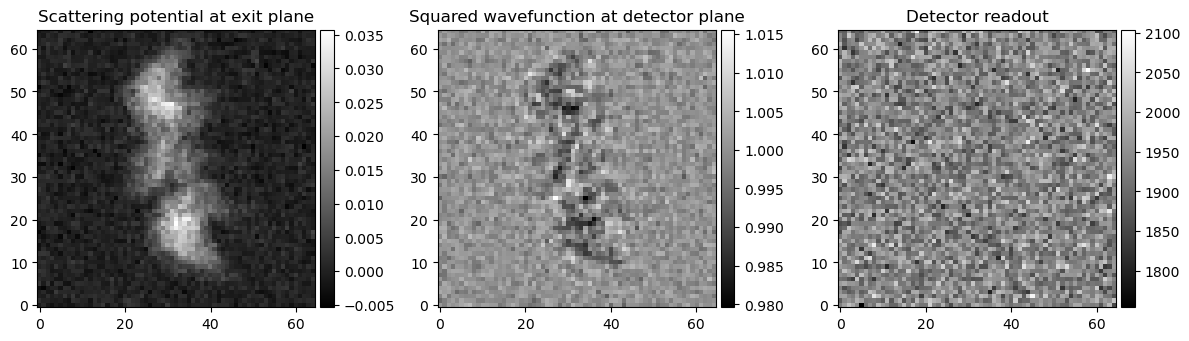

In [10]:
# Simulate each image, drawing from the stochastic parts of the model
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(
    scattering_pipeline.sample(key),
    fig,
    ax1,
    label="Scattering potential at exit plane",
)
im2 = plot_image(
    optics_pipeline.sample(key),
    fig,
    ax2,
    label="Squared wavefunction at detector plane",
)
im3 = plot_image(detector_pipeline.sample(key), fig, ax3, label="Detector readout")
plt.tight_layout()

What if we did not want to include noise in the simulation? In this case, the three outputs are

**1. If there is no `Instrument`:** The returned "image" is the scattering potential in the exit plane including stochasticity, which here we use in the `solvent` model.

**2. If the `Instrument` just has an optics model:** Again, the returned "image" is the squared wavefunction in the detector plane.

**3. If the `Instrument` has optics, dose, and detector models:** Now, the returned "image" is the expected number of electron counts for each pixel. This is nothing but the poisson rate.

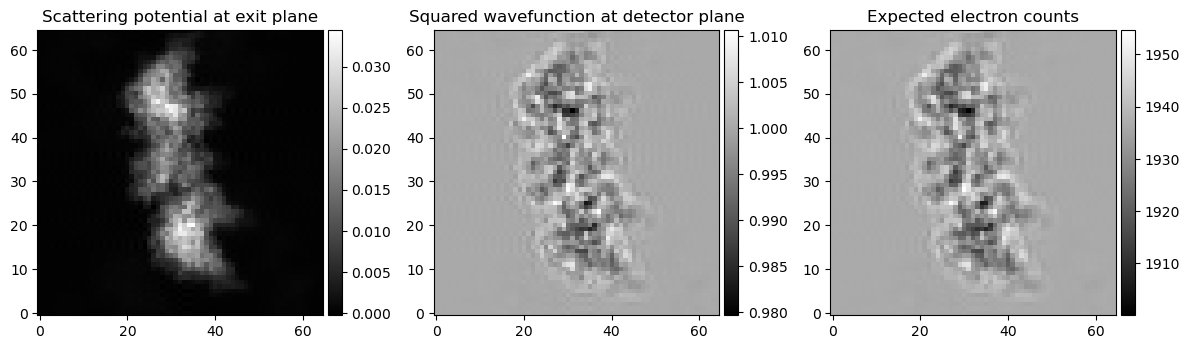

In [11]:
# Simulate each image without stochasticity
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(
    scattering_pipeline.render(), fig, ax1, label="Scattering potential at exit plane"
)
im2 = plot_image(
    optics_pipeline.render(), fig, ax2, label="Squared wavefunction at detector plane"
)
im3 = plot_image(detector_pipeline.render(), fig, ax3, label="Expected electron counts")
plt.tight_layout()